In [1]:
from datetime import datetime, timedelta
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import numpy as np
import metpy.calc as mcalc
from metpy.units import units, concatenate
from metpy.plots import SkewT

Just some helper code to make things easier. `metpy_units_handler` plugins into siphon to automatically add units to variables. `post_process_data` is used to clean up some oddities from the NCSS point feature collection.

In [2]:
units.define('degrees_north = 1 degree')
units.define('degrees_east = 1 degree')
unit_remap = dict(inches='inHg', Celsius='celsius')
def metpy_units_handler(vals, unit):
    arr = np.array(vals)
    if unit:
        unit = unit_remap.get(unit, unit)
        arr = arr * units(unit)
    return arr

# Fix dates and sorting
def sort_list(list1, list2):
    return [l1 for (l1, l2) in sorted(zip(list1, list2), key=lambda i: i[1])]

def post_process_data(data):
    data['time'] = [datetime.strptime(d.decode('ascii'), '%Y-%m-%d %H:%M:%SZ') for d in data['time']]
    ret = dict()
    for key,val in data.items():
        try:
            val = units.Quantity(sort_list(val.magnitude.tolist(), data['time']), val.units)
        except AttributeError:
            val = sort_list(val, data['time'])
        ret[key] = val
    return ret

# METAR Meteogram

First we need to grab the catalog for the METAR feature collection data from http://thredds.ucar.edu/thredds/catalog.html

In [3]:
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr')

Set up NCSS access to the dataset

In [4]:
ds = list(cat.datasets.values())[0]

In [5]:
ncss = NCSS(ds.access_urls['NetcdfSubset'])
ncss.unit_handler = metpy_units_handler

What variables do we have available? (Hint: try a `variables` attribute.)

Create a query for the last 7 days of data for a specific lon/lat point. We should ask for: air temperature, dewpoint temperature, wind speed, and wind direction.

In [6]:
now = datetime.utcnow()
query = ncss.query().accept('csv')
query.lonlat_point(-97, 35.25).time_range(now - timedelta(days=7), now)
query.variables('air_temperature', 'dew_point_temperature', 'wind_speed', 'wind_from_direction')

var=wind_from_direction&var=dew_point_temperature&var=air_temperature&var=wind_speed&time_end=2015-06-22T15%3A37%3A31.569033&time_start=2015-06-15T15%3A37%3A31.569033&longitude=-97&latitude=35.25&accept=csv

Get the data

In [7]:
data = ncss.get_data(query)
data = post_process_data(data)  # Fixes for NCSS point

## Heat Index

First, we need relative humidity:
    $$RH = e / e_s$$

In [8]:
e = mcalc.saturation_vapor_pressure(data['dew_point_temperature'])
e_s = mcalc.saturation_vapor_pressure(data['air_temperature'])
rh = e / e_s

Calculate heat index:

In [9]:
# RH should be [0, 100]
hi = mcalc.heat_index(data['air_temperature'], rh * 100)

Plot the temperature, dewpoint, and heat index. Bonus points to also plot wind speed and direction.

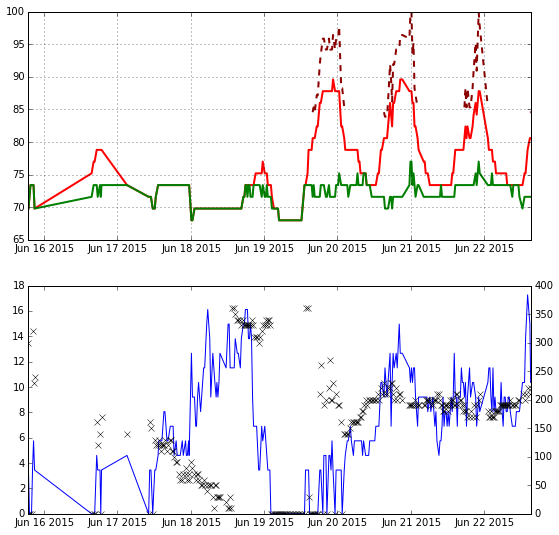

In [10]:
import matplotlib.pyplot as plt
times = data['time']
fig, axes = plt.subplots(2, 1, figsize=(9, 9))
axes[0].plot(times, data['air_temperature'].to('degF'), 'r', linewidth=2)
axes[0].plot(times, data['dew_point_temperature'].to('degF'), 'g', linewidth=2)
axes[0].plot(times, hi, color='darkred', linestyle='--', linewidth=2)
axes[0].grid(True)
axes[1].plot(times, data['wind_speed'].to('mph'), 'b')
twin = plt.twinx(axes[1])
twin.plot(times, data['wind_from_direction'], 'kx')

#Sounding

First grab the catalog for the Best dataset from the GSD HRRR from http://thredds.ucar.edu/thredds/catalog.html

In [11]:
cat = TDSCatalog('http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/grib/HRRR/CONUS_3km/wrfprs/catalog.xml?dataset=grib/HRRR/CONUS_3km/wrfprs/Best')

Set up NCSS access to the dataset

In [12]:
best_ds = list(cat.datasets.values())[0]

In [13]:
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])
ncss.unit_handler = metpy_units_handler

What variables do we have?

In [14]:
ncss.variables

{'Absolute_vorticity_isobaric',
 'Cloud_ice_isobaric',
 'Cloud_mixing_ratio_isobaric',
 'Dewpoint_temperature_isobaric',
 'Geopotential_height_isobaric',
 'Graupel_snow_pellets_isobaric',
 'Rain_mixing_ratio_isobaric',
 'Relative_humidity_isobaric',
 'Snow_mixing_ratio_isobaric',
 'Specific_humidity_isobaric',
 'Temperature_isobaric',
 'Vertical_velocity_pressure_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric'}

Set up a query for the most recent set of data from a point. We should request temperature, dewpoint, and U and V.

In [15]:
query = ncss.query().accept('csv')
query.lonlat_point(-105, 40).time(datetime.utcnow())
query.variables('Temperature_isobaric', 'Dewpoint_temperature_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')

var=v-component_of_wind_isobaric&var=Temperature_isobaric&var=Dewpoint_temperature_isobaric&var=u-component_of_wind_isobaric&time=2015-06-22T15%3A38%3A02.264123&longitude=-105&latitude=40&accept=csv

Get the data

In [16]:
data = ncss.get_data(query)

In [17]:
T = data['Temperature_isobaric'].to('degC')
Td = data['Dewpoint_temperature_isobaric'].to('degC')
p = data['vertCoord'].to('mbar')

Plot a sounding of the data

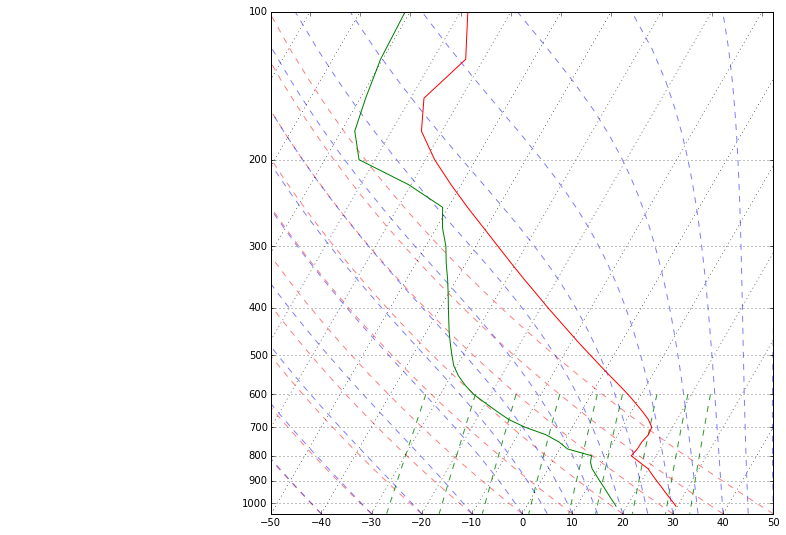

In [18]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig=fig)
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.ax.set_ylim(1050, 100)
skew.plot_mixing_lines()
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()

Also calculate the parcel profile and add that to the plot

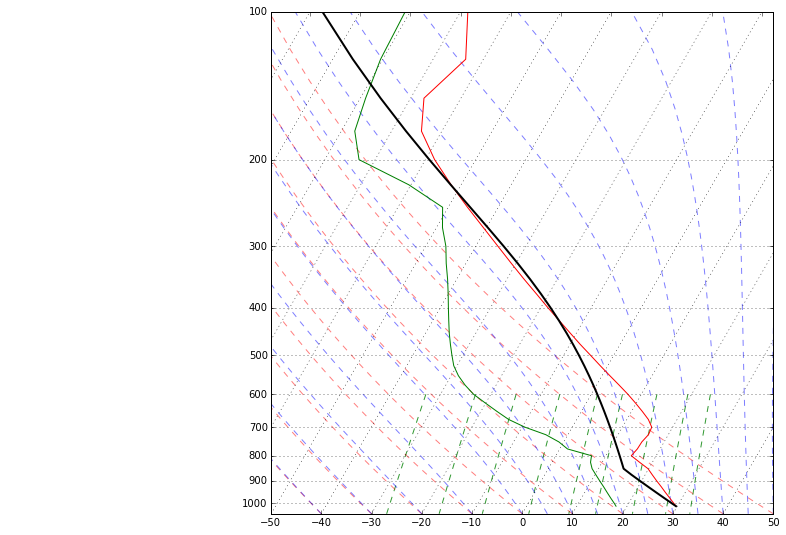

In [19]:
prof = mcalc.parcel_profile(p[::-1], T[-1], Td[-1])
skew.plot(p[::-1], prof.to('degC'), 'k', linewidth=2)
fig

Let's also plot the location of the LCL and the 0 isotherm as well:

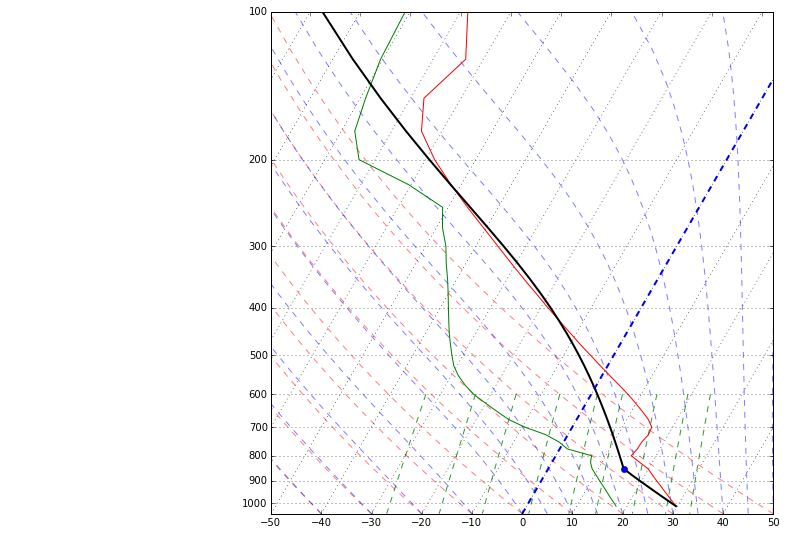

In [20]:
lcl = mcalc.lcl(p[-1], T[-1], Td[-1])
lcl_temp = mcalc.dry_lapse(concatenate((p[-1], lcl)), T[-1])[-1].to('degC')
skew.plot(lcl, lcl_temp, 'bo')
skew.ax.axvline(0, color='blue', linestyle='--', linewidth=2)
fig